# Preference Learning

### Mikołaj Nowak 151813  
### Anna Roszkiewicz 151883

---

## Wprowadzenie

Celem projektu jest przeprowadzenie eksperymentów z zakresu *preference learning* z wykorzystaniem różnych modeli klasyfikacyjnych.  
Analiza będzie obejmowała zarówno interpretowalne metody klasyczne, jak i modele oparte na sieciach neuronowych.  

---

## Import niezbędnych bibliotek

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import shap
import torch
import torch.nn as nn
from typing import Any, Tuple
from functools import partial
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from torchviz import make_dot
from IPython.display import SVG, display
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

---

## Wybrany zbiór danych

Jako zbiór danych wybraliśmy Mammographic Mass Dataset, ponieważ:

- Zawiera ponad 800 przykładów,
- Obejmuje pięć cech wejściowych, które są monotoniczne,
- Klasa decyzyjna przyjmuje dwie wartości (`0` - łagodny guz, `1` - złośliwy guz),
- Jest to najbardziej kompletny i czysty zbiór spośród dostępnych na stronie  
  [Monotone Learning Datasets – Uni Paderborn](https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets) pobrany z [Kaggle](https://www.kaggle.com/datasets/overratedgman/mammographic-mass-data-set)

In [2]:
import pandas as pd

df = pd.read_csv('data/mammographic.csv')
df.head()

BI-RADS  Age  Shape  Margin  Density  Severity
0        5   67      3       5        3         1
1        5   58      4       5        3         1
2        4   28      1       1        3         0
3        5   57      1       5        3         1
4        5   76      1       4        3         1

In [3]:
X, y = df.drop(columns=['Severity']), df['Severity']
X.describe()

BI-RADS         Age       Shape      Margin     Density
count  830.000000  830.000000  830.000000  830.000000  830.000000
mean     4.393976   55.781928    2.781928    2.813253    2.915663
std      1.888371   14.671782    1.242361    1.567175    0.350936
min      0.000000   18.000000    1.000000    1.000000    1.000000
25%      4.000000   46.000000    2.000000    1.000000    3.000000
50%      4.000000   57.000000    3.000000    3.000000    3.000000
75%      5.000000   66.000000    4.000000    4.000000    3.000000
max     55.000000   96.000000    4.000000    5.000000    4.000000

In [4]:
y.value_counts()

Severity
0    427
1    403
Name: count, dtype: int64

In [5]:
df = df[df.iloc[:, 0] != 55]

---

## Opis zbioru danych

Zbiór danych **mammographic** zawiera **830 przykładów**, z czego każdy opisany jest za pomocą **5 kryteriów (cech)** oraz **klasy decyzyjnej** (`Severity`). Dane nie zawierają brakujących wartości (`NULL`). Wszystkie cechy są zapisane jako liczby całkowite reprezentujące skategoryzowane wartości (np. poziomy ryzyka, typy anatomiczne itp.).

#### Kolumny w zbiorze:
- **BI-RADS** – ocena radiologiczna w skali BI-RADS (1–5), im wyższa wartość, tym wyższe podejrzenie złośliwości zmiany.
- **Age** – wiek pacjentki (w latach).
- **Shape** – kształt zmiany:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = round, 2 = oval, 3 = lobular, 4 = irregular.
- **Margin** – granica zmiany:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = circumscribed, 2 = microlobulated, 3 = obscured, 4 = ill-defined, 5 = spiculated.
- **Density** – gęstość zmiany w obrazie:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = high, 2 = iso, 3 = low, 4 = fat-containing.
- **Severity** – klasa decyzyjna:  
  &nbsp;&nbsp;&nbsp;&nbsp;0 = łagodna zmiana, 1 = złośliwa zmiana.

Zbiór danych jest **w miarę zbalansowany** – liczba przykładów w każdej klasie (łagodna vs złośliwa zmiana) jest zbliżona.
Przynajmniej trzy cechy – BI-RADS, Age i Margin – można uznać za monotoniczne względem klasy decyzyjnej (Severity). Pozostałe cechy, takie jak Shape i Density, również wykazują tendencje monotoniczne, co czyni zbiór odpowiednim do dalszej analizy preferencji.


### Przygotowanie danych

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

---

## Regresja Logistyczna

### Trening modelu

In [7]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Predykcje

In [8]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

### Metryki

In [9]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8029
F1 score: 0.8057
AUC: 0.8804


### Wizualizacja współczynników regresji (ważność cech)

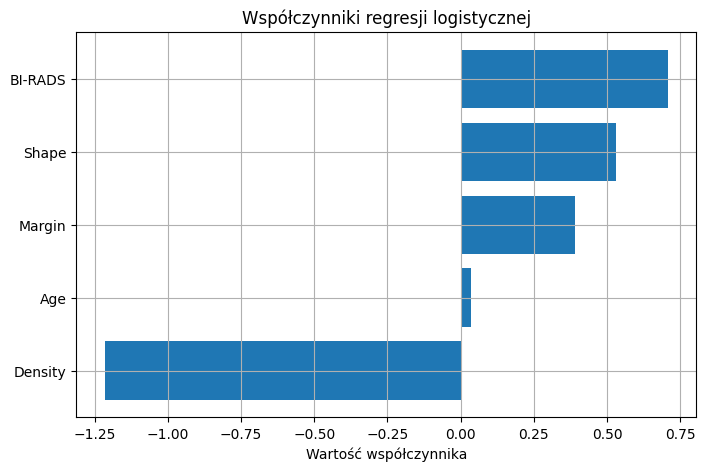

In [10]:
features = X.columns
coef = model.coef_[0]
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient')

plt.figure(figsize=(8, 5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Współczynniki regresji logistycznej')
plt.xlabel('Wartość współczynnika')
plt.grid(True)
plt.show()

### Interpretacja wizualizacji

- BI-RADS ma największy pozytywny wpływ na decyzję modelu — im wyższa wartość tej cechy, tym większe prawdopodobieństwo klasy 1.
- Shape i Margin również pozytywnie wpływają na klasyfikację do klasy 1, choć w mniejszym stopniu.
- Age ma bardzo niewielki, ale dodatni wpływ.
- Density działa odwrotnie — wyższe wartości tej cechy obniżają prawdopodobieństwo przypisania do klasy 1.

## Wyjaśnienie wybranych decyzji

In [11]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 3, replace=False)

intercept = model.intercept_[0]  
coef = model.coef_[0]

### Obliczanie minimalnej zmiany metodą gradientową

In [12]:
def minimal_change_to_flip_decision_logistic_regression(x, coef, intercept):
    z0 = np.dot(coef, x) + intercept
    changes = {}
    for i, w in enumerate(coef):
        if w != 0:
            delta = -z0 / w
            changes[x.index[i]] = delta
        else:
            changes[x.index[i]] = np.inf
    df = pd.DataFrame({
        'Feature': list(changes.keys()),
        'Current Value': x.values,
        'Coefficient': coef,
        'Required Change': list(changes.values()),
        'Value After Change': x.values + np.array(list(changes.values()))
    })
    return df

In [13]:
def sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, original_pred):
    print("\nPróbkowanie zmienionych cech i wynik predykcji:")

    x_float = x.astype(float)

    for i, row in df_changes.iterrows():
        if np.isinf(row['Required Change']):
            print(f"- Cecha {row['Feature']} ma współczynnik 0, brak wpływu na decyzję.")
            continue
        
        x_modified = x_float.copy()
        delta = row['Required Change'] * 1.01
        x_modified[row['Feature']] += delta
        
        linear_sum_mod = np.dot(coef, x_modified) + intercept
        prob_mod = 1 / (1 + np.exp(-linear_sum_mod))
        pred_mod = model.predict(pd.DataFrame([x_modified], columns=X_test.columns))[0]
        
        changed = "TAK" if pred_mod != original_pred else "NIE"
        
        print(f"- Cecha {row['Feature']}: zmiana o {delta:.4f}, nowa wartość {x_modified[row['Feature']]:.4f}")
        print(f"  Prawdopodobieństwo klasy 1 po zmianie: {prob_mod:.4f}")
        print(f"  Predykcja po zmianie: {pred_mod}, zmiana klasy: {changed}")

In [14]:
masker = shap.maskers.Independent(X_test)
explainer = shap.LinearExplainer(model, masker=masker)

### Przykład 1

In [15]:
idx = random_indices[0]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 1 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 1 (indeks 161 w zbiorze testowym):
Wartości cech: BI-RADS=4, Age=62, Shape=4, Margin=2, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    2.835521
Age        2.209140
Shape      2.121616
Margin     0.779614
Density   -3.648152
Name: 320, dtype: float64
Sumaryczna wartość liniowa (z interceptem): 0.0996
Prawdopodobieństwo klasy 1: 0.5249
Przewidywana klasa: 1

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              4     0.708880        -0.140510            3.859490
1      Age             62     0.035631        -2.795429           59.204571
2    Shape              4     0.530404        -0.187790            3.812210
3   Margin              2     0.389807        -0.255523            1.744477
4  Density              3    -1.216051         0.081908            3.081908


In [16]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o -0.1419, nowa wartość 3.8581
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -2.8234, nowa wartość 59.1766
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -0.1897, nowa wartość 3.8103
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -0.2581, nowa wartość 1.7419
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Density: zmiana o 0.0827, nowa wartość 3.0827
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK


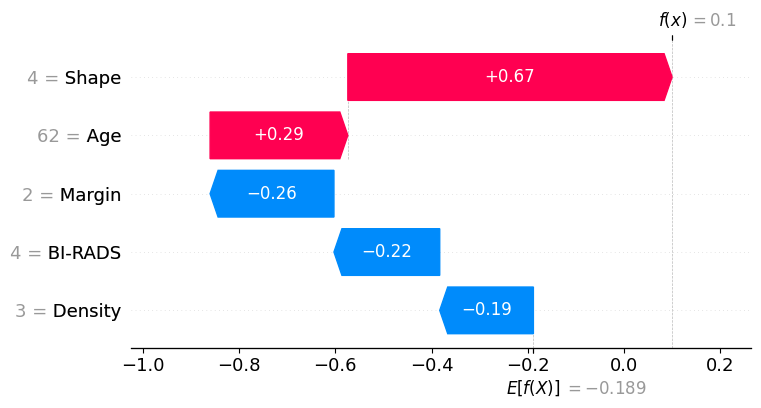

In [17]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 1, jednak decyzja jest niepewna, ponieważ suma ważonych cech z interceptem była blisko zera, dając prawdopodobieństwo klasy 1 tylko trochę większe od 0.50. 

- Największy pozytywny wpływ miały cechy: BI-RADS, Age i Shape.
- Cecha Density silnie obniżała sumę liniową, działając przeciwnie.
- Decyzja to efekt równowagi między cechami silnie pozytywnymi a jednym ujemnym czynnikiem.

Minimalna zmiana jednej cechy potrzebna do zmiany klasy jest odwrotnie proporcjonalna do jej współczynnika i przesuwa sumę liniową na drugą stronę progu decyzyjnego.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.

### Przykład 2

In [18]:
idx = random_indices[1]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 2 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 2 (indeks 15 w zbiorze testowym):
Wartości cech: BI-RADS=4, Age=58, Shape=2, Margin=1, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    2.835521
Age        2.066615
Shape      1.060808
Margin     0.389807
Density   -3.648152
Name: 622, dtype: float64
Sumaryczna wartość liniowa (z interceptem): -1.4935
Prawdopodobieństwo klasy 1: 0.1834
Przewidywana klasa: 0

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              4     0.708880         2.106894            6.106894
1      Age             58     0.035631        41.916399           99.916399
2    Shape              2     0.530404         2.815845            4.815845
3   Margin              1     0.389807         3.831473            4.831473
4  Density              3    -1.216051        -1.228185            1.771815


In [19]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o 2.1280, nowa wartość 6.1280
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 42.3356, nowa wartość 100.3356
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 2.8440, nowa wartość 4.8440
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 3.8698, nowa wartość 4.8698
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Density: zmiana o -1.2405, nowa wartość 1.7595
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK


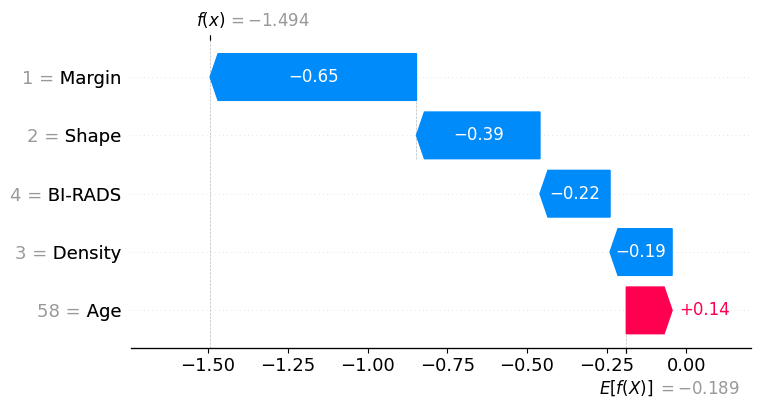

In [20]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 0 z dużą pewnością, ponieważ suma ważonych cech z interceptem była znacznie poniżej zera, dając prawdopodobieństwo klasy 1 około 0.18.

- Największy pozytywny wpływ miały cechy: BI-RADS, Age, Shape i Margin, jednak ich suma nie była wystarczająca.
- Cecha Density miała silny negatywny wpływ, jeszcze bardziej obniżając sumę liniową.
- Decyzja wynika z przewagi cech przeciwnych klasie 1.

Minimalna zmiana jednej cechy potrzebna do zmiany klasy jest odwrotnie proporcjonalna do jej współczynnika i wymaga przesunięcia sumy liniowej ponad próg decyzyjny.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.


### Przykład 3

In [21]:
idx = random_indices[2]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 3 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 3 (indeks 73 w zbiorze testowym):
Wartości cech: BI-RADS=5, Age=53, Shape=4, Margin=5, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    3.544401
Age        1.888459
Shape      2.121616
Margin     1.949036
Density   -3.648152
Name: 479, dtype: float64
Sumaryczna wartość liniowa (z interceptem): 1.6572
Prawdopodobieństwo klasy 1: 0.8399
Przewidywana klasa: 1

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              5     0.708880        -2.337806            2.662194
1      Age             53     0.035631       -46.510372            6.489628
2    Shape              4     0.530404        -3.124458            0.875542
3   Margin              5     0.389807        -4.251397            0.748603
4  Density              3    -1.216051         1.362792            4.362792


In [22]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o -2.3612, nowa wartość 2.6388
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -46.9755, nowa wartość 6.0245
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -3.1557, nowa wartość 0.8443
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -4.2939, nowa wartość 0.7061
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Density: zmiana o 1.3764, nowa wartość 4.3764
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK


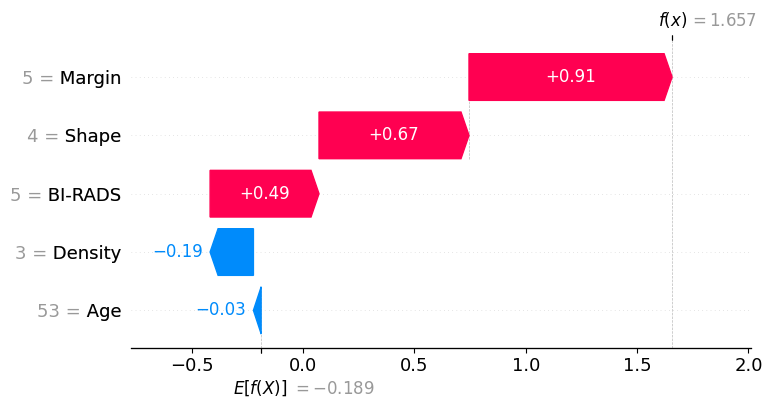

In [23]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 1 z wysokim prawdopodobieństwem, ponieważ suma ważonych cech z interceptem była wyraźnie powyżej zera.

- Największy pozytywny wpływ miały cechy: BI-RADS, Shape, Margin oraz Age, które znacząco podniosły sumę liniową.
- Cecha Density miała silny negatywny wpływ, częściowo obniżając sumę, ale nie na tyle, by zmienić decyzję.
- Decyzja modelu wynika z przewagi pozytywnych wartości cech nad negatywnym wpływem Density.

Minimalna zmiana wartości cech potrzebna do zmiany decyzji modelu jest odwrotnie proporcjonalna do ich współczynników i oznacza przesunięcie sumy liniowej poniżej progu decyzyjnego.

Próbkowanie wartości cech z niewielką nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.

## Interpretacja modelu

Regresja logistyczna przewiduje prawdopodobieństwo wystąpienia złośliwego guza piersi (klasa 1) na podstawie wartości cech. Współczynniki modelu oraz wartości SHAP pokazują, że największy wpływ na decyzję mają cechy BI-RADS (najsilniejszy, pozytywny wpływ), Density (negatywny wpływ), a w mniejszym stopniu Shape i Margin. Wiek (Age) ma niewielką wagę, ale ze względu na dużą skalę wartości, jego wpływ na decyzję modelu jest zauważalny i częściowo rekompensuje niski współczynnik.

Wszystkie cechy mają charakter monotoniczny, co jest zgodne z naturą modelu liniowego — wyższe wartości niektórych cech zwiększają prawdopodobieństwo (BI-RADS, Shape, Margin, Age), inne je obniżają (Density). Nie zaobserwowano progów preferencji ani obszarów nierozróżnialności — wpływ cech zmienia się płynnie.

### Wizualizacja funkcji cząstkowych zależności

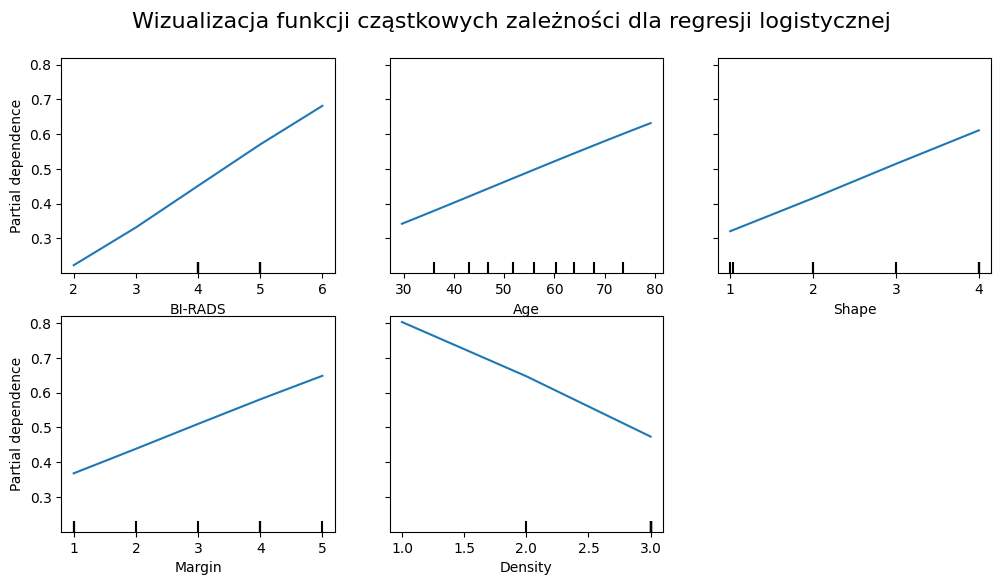

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test, features, ax=ax, grid_resolution=50)
plt.suptitle('Wizualizacja funkcji cząstkowych zależności dla regresji logistycznej', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

Wykresy funkcji cząstkowych zależności pokazują, jak zmiana wartości poszczególnych cech wpływa na przewidywane prawdopodobieństwo przypisania do klasy 1, przy założeniu stałości pozostałych cech. Zależności mają kształt niemal liniowy, co jest zgodne z liniowym charakterem regresji logistycznej.

Wyniki uzyskane za pomocą tej techniki potwierdzają wcześniejsze wnioski dotyczące wpływu cech na decyzje modelu. Cecha BI-RADS ma największy wpływ, a Density działa w przeciwnym kierunku, co jest spójne z analizą współczynników regresji i wartości SHAP.


---

## ANN-MCDA: ANN-UTADIS

Poniżej importujemy niezbędne moduły zaprezentowane na zajęciach laboratoryjnych, które pozwalają na implementację modelu ANN-UTADIS oraz jego analizę i interpretację.

In [25]:
class CriterionLayerCombine(nn.Module):

    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        min_weight: float = 0.001,
        **kwargs
    ):
        super().__init__()
        self.min_weight = min_weight
        self.weight = nn.Parameter(
            torch.FloatTensor(num_hidden_components, num_criteria)
        )
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.weight, 0.2, 1.0)
        self.weight.data = self.weight.data / torch.sum(self.weight.data)

    def compute_weight(self) -> torch.Tensor:
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_weight
        return self.weight

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return (input * self.compute_weight()).sum(1)


In [26]:
class CriterionLayerSpread(nn.Module):
    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        input_range: Tuple[float, float] = (0, 1),
        normalize_bias: bool = False,
        **kwargs
    ) -> None:
        super().__init__()
        self.num_criteria = num_criteria
        input_range = (-input_range[0], -input_range[1])
        self.max_bias = max(input_range)
        self.min_bias = min(input_range)
        self.normalize_bias = normalize_bias
        self.bias = nn.Parameter(torch.FloatTensor(num_hidden_components, num_criteria))
        self.weight = nn.Parameter(
            torch.FloatTensor(num_hidden_components, num_criteria)
        )
        self.reset_parameters()
        self.min_w = 0

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.weight, 1, 10.0)
        nn.init.uniform_(self.bias, self.min_bias, self.max_bias)

    def compute_bias(self) -> torch.Tensor:
        if self.normalize_bias:
            return torch.clamp(self.bias, self.min_bias, self.max_bias)
        else:
            return self.bias

    def compute_weight(self) -> torch.Tensor:
        # return torch.clamp(self.weight, 0.0)
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_w
        return self.weight

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = input.view(-1, 1, self.num_criteria)
        return (x + self.compute_bias()) * self.compute_weight()


In [27]:
class LeakyHardSigmoid(nn.Module):

    def __init__(self, slope: float = 0.01, **kwargs):
        super().__init__()
        self.slope = slope

    def set_slope(self, val: float) -> None:
        self.slope = val

    def forward(self, input):
        return F.leaky_relu(1.0 - F.leaky_relu(1 - input, self.slope), self.slope)


In [28]:
class MonotonicLayer(nn.Sequential):
    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        slope: float = 0.01,
        **kwargs
    ):
        super().__init__()
        self.criterion_layer_spread = CriterionLayerSpread(
            num_criteria, num_hidden_components, **kwargs
        )
        self.activation_function = LeakyHardSigmoid(slope=slope, **kwargs)
        self.criterion_layer_combine = CriterionLayerCombine(
            num_criteria, num_hidden_components, **kwargs
        )

    def set_slope(self, val: float) -> None:
        self.activation_function.set_slope(val)

    def forward(self, x):
        for module in self._modules.values():
            x = module(x)
        return x


In [29]:
class Uta(nn.Sequential):

    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        slope: float = 0.01,
        **kwargs
    ):
        super().__init__()
        self.monotonic_layer = MonotonicLayer(
            num_criteria, num_hidden_components, slope, **kwargs
        )

    def set_slope(self, val: float) -> None:
        self.monotonic_layer.set_slope(val)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.monotonic_layer(input)
        return x.sum(1)


In [30]:
class Hook:

    def __init__(self, layer: torch.nn.Module, func: callable):
        self.hook = layer.register_forward_hook(partial(func, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()


def append_output(hook: Hook, mod: torch.nn.Module, input: Any, output: torch.Tensor):
    if not hasattr(hook, "stats"):
        hook.stats = []
    if not hasattr(hook, "name"):
        hook.name = mod.__class__.__name__
    data = hook.stats
    data.append(output.data)


def get_simple_input(val: float, num_criteria: int) -> torch.Tensor:

    input_tensor = torch.full((1, 1, num_criteria), val, dtype=torch.float)
    return input_tensor.cpu()


class NumpyDataset(Dataset):
    def __init__(self, data: np.array, targets: np.array):
        self.data = torch.Tensor(data)
        self.targets = torch.LongTensor(targets.astype(int))

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self) -> int:
        return len(self.data)


def CreateDataLoader(data: np.array, targets: np.array) -> DataLoader:
    dataset = NumpyDataset(data, targets)
    return DataLoader(dataset, batch_size=len(dataset))


def Regret(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    loss_fn = torch.nn.BCEWithLogitsLoss()
    return loss_fn(output.view(-1), target.float())

def Accuracy(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    probs = torch.sigmoid(output)
    preds = (probs > 0.5).int()
    return (target == preds).float().mean().item()

def AUC(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    probs = torch.sigmoid(output).detach().cpu().numpy()
    targets = target.detach().cpu().numpy()
    return roc_auc_score(targets, probs)


class ScoreTracker:
    def __init__(self):
        self.losses = []
        self.auc_scores = []
        self.acc_scores = []
        self.f1_scores = []

    def append(self, loss: float, auc: float, acc: float, f1: float = None) -> None:
        self.losses.append(loss)
        self.auc_scores.append(auc)
        self.acc_scores.append(acc)
        if f1 is not None:
            self.f1_scores.append(f1)

    def add(self, outputs: torch.FloatTensor, labels: torch.LongTensor) -> None:
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_true = labels.detach().cpu().numpy()

        loss = float(Regret(outputs, labels).item())
        auc = AUC(outputs, labels)
        acc = Accuracy(outputs, labels)
        f1 = f1_score(y_true, preds)

        self.losses.append(loss)
        self.auc_scores.append(auc)
        self.acc_scores.append(acc)
        self.f1_scores.append(f1)


def Train(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    path: str,
    lr: float = 0.01,
    epoch_nr: int = 200,
    slope_decrease: bool = False,
) -> Tuple[float, float, ScoreTracker, ScoreTracker]:
    optimizer = optim.AdamW(
        model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=0.01
    )
    # Add a learninge rate scheduler to the optimizer
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epoch_nr
    )
    best_acc = 0.0
    best_auc = 0.0
    stats_train = ScoreTracker()
    stats_test = ScoreTracker()
    # Decrease the slope of the leaky hard sigmoid activation function in each epoch
    slopes = np.linspace(0.01, 0.003, epoch_nr)
    for epoch in tqdm(range(epoch_nr)):
        if slope_decrease:
            model.set_slope(slopes[epoch])
        for _, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = Regret(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            y_true = labels.detach().cpu().numpy()
            f1 = f1_score(y_true, preds)

            acc = Accuracy(outputs, labels)
            auc = AUC(outputs, labels)
            stats_train.append(loss.item(), auc, acc, f1)

        with torch.no_grad():
            for _, data in enumerate(test_dataloader, 0):
                inputs, labels = data
                outputs = model(inputs)
                stats_test.add(outputs, labels)

        # Save the model if the accuracy is better than the previous best
        if acc > best_acc:
            best_acc = acc
            best_auc = auc

            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                path,
            )

    return (
        best_acc,
        best_auc,
        stats_train,
        stats_test,
    )

In [31]:
class ThresholdLayer(nn.Module):

    def __init__(self, threshold: float = None, requires_grad: bool = True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x - self.threshold

In [32]:
class NormLayer(nn.Module):

    def __init__(self, method_instance: torch.nn.Module, num_criteria: int):
        super().__init__()
        self.method_instance = method_instance
        self.num_criteria = num_criteria
        self.thresholdLayer = ThresholdLayer(0.5)

    def set_slope(self, slope: float):
        self.method_instance.set_slope(slope)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        self.out = self.method_instance(input)

        zero_input = torch.zeros(self.num_criteria).view(1, 1, -1).to(self.out.device)
        zero = self.method_instance(zero_input)
        one = self.method_instance(zero_input + 1)

        self.out = (self.out - zero) / (one - zero)
        return self.thresholdLayer(self.out)

### Przygotowanie danych

In [33]:
df = pd.read_csv('data/mammographic.csv')
df = df[df.iloc[:, 0] != 55]

num_criteria = 5
feature_names = df.columns[:num_criteria].tolist()

data_input = df.iloc[:, :num_criteria]
data_target = df.iloc[:, num_criteria]

data_input = data_input.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

### Trenowanie modelu

In [34]:
num_hidden_components = 30

uta = Uta(num_criteria, num_hidden_components)
model = NormLayer(uta, num_criteria)

UTA_PATH = "models/ann_utadis.pt"

(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
) = Train(
    model,
    train_dataloader,
    test_dataloader,
    UTA_PATH,
    epoch_nr=2000,
    lr=0.001,
    slope_decrease=True
)

100%|██████████| 2000/2000 [00:14<00:00, 139.02it/s]


### Metryki

In [35]:
print("=== Final Evaluation Metrics ===")
print(f"Train Accuracy: {round(stats_train.acc_scores[-1], 4)}")
print(f"Test Accuracy:  {round(stats_test.acc_scores[-1], 4)}")
print(f"Train AUC:      {round(stats_train.auc_scores[-1], 4)}")
print(f"Test AUC:       {round(stats_test.auc_scores[-1], 4)}")
print(f"Train F1:       {round(stats_train.f1_scores[-1], 4)}")
print(f"Test F1:        {round(stats_test.f1_scores[-1], 4)}")

=== Final Evaluation Metrics ===
Train Accuracy: 0.7662
Test Accuracy:  0.8313
Train AUC:      0.8371
Test AUC:       0.8952
Train F1:       0.7936
Test F1:        0.825


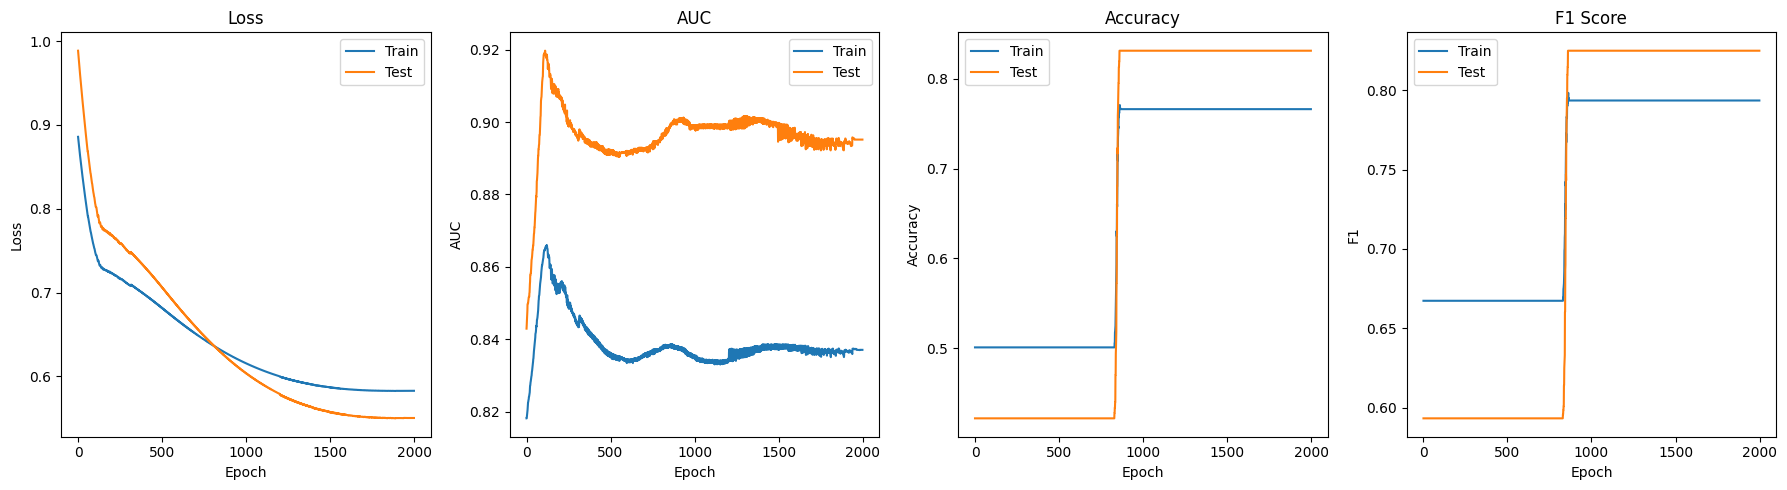

In [36]:
fig = plt.figure(figsize=(18, 5))

# Loss
ax = fig.add_subplot(1, 4, 1)
ax.plot(stats_train.losses, label='Train')
ax.plot(stats_test.losses, label='Test')
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# AUC
ax = fig.add_subplot(1, 4, 2)
ax.plot(stats_train.auc_scores, label='Train')
ax.plot(stats_test.auc_scores, label='Test')
ax.set_title('AUC')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.legend()

# Accuracy
ax = fig.add_subplot(1, 4, 3)
ax.plot(stats_train.acc_scores, label='Train')
ax.plot(stats_test.acc_scores, label='Test')
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# F1
ax = fig.add_subplot(1, 4, 4)
ax.plot(stats_train.f1_scores, label='Train')
ax.plot(stats_test.f1_scores, label='Test')
ax.set_title('F1 Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend()

plt.tight_layout()
plt.show()

- Model zaczął poprawnie różnicować klasy dopiero po zwiększeniu liczby iteracji – dopiero wtedy prawdopodobieństwa klasyfikacji zaczęły spadać poniżej 0.50, co świadczy o dojrzewaniu modelu w procesie uczenia.  
- Testowe metryki (AUC, Accuracy) są porównywalne lub nawet nieco lepsze niż treningowe, co sugeruje brak przeuczenia i dobre zdolności generalizacyjne modelu.  
- Wysoka wartość AUC na zbiorze testowym potwierdza, że model skutecznie rozdziela klasy przy różnych progach decyzyjnych.  
- Nieco niższy F1 na zbiorze testowym wskazuje, że mimo dobrej ogólnej skuteczności, model może mieć trudności z równoważeniem precyzji i czułości w praktyce.  
- Gwałtowne zwiększenie accuracy nastąpiło dopiero po osiągnięciu odpowiedniego poziomu iteracji, co potwierdza, że zbyt wczesne zatrzymanie procesu uczenia skutkowałoby niedostatecznym dopasowaniem modelu.


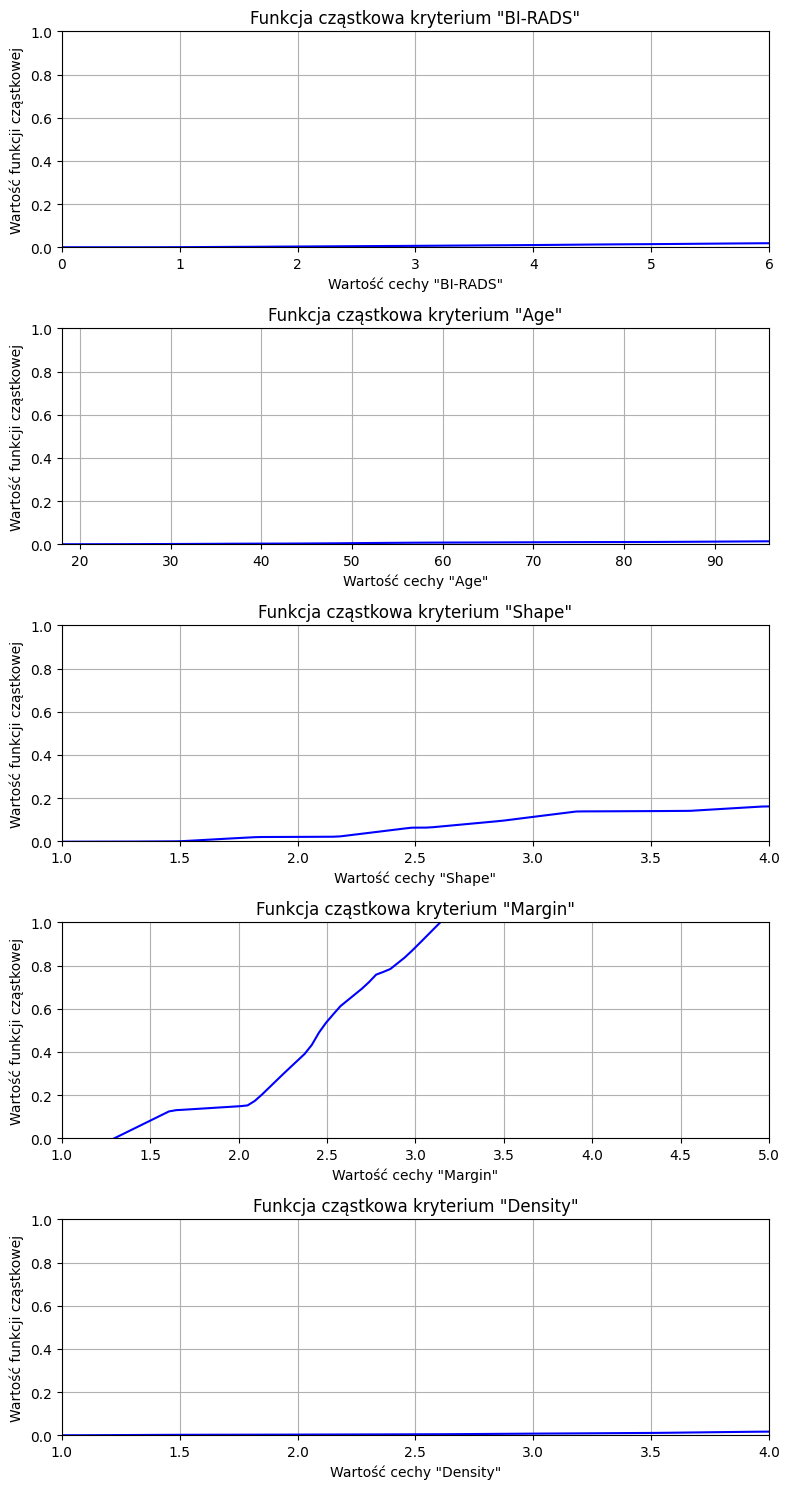

In [37]:
def plot_partial_functions_uta_dis(monotonic_layer, data_input, feature_names):
    num_criteria = data_input.shape[1]
    feature_mins = data_input.min(axis=0)
    feature_maxs = data_input.max(axis=0)

    fig, axes = plt.subplots(num_criteria, 1, figsize=(8, 3 * num_criteria))
    if num_criteria == 1:
        axes = [axes]

    for crit in range(num_criteria):
        min_val = feature_mins[crit]
        max_val = feature_maxs[crit]

        x_vals = torch.linspace(min_val, max_val, 100).unsqueeze(1)
        x_scaled = (x_vals - min_val) / (max_val - min_val)
        x_input = torch.zeros(100, num_criteria)
        x_input[:, crit] = x_scaled.squeeze()

        with torch.no_grad():
            spread_out = monotonic_layer.criterion_layer_spread(x_input)
            activated = monotonic_layer.activation_function(spread_out)
            combined = monotonic_layer.criterion_layer_combine(activated)

        axes[crit].plot(x_vals.numpy(), combined[:, crit].numpy(), color='blue')
        axes[crit].set_title(f'Funkcja cząstkowa kryterium "{feature_names[crit]}"')
        axes[crit].set_xlabel(f'Wartość cechy "{feature_names[crit]}"')
        axes[crit].set_ylabel('Wartość funkcji cząstkowej')
        axes[crit].set_xlim(min_val, max_val)
        axes[crit].set_ylim(0, 1)
        axes[crit].grid(True)

    plt.tight_layout()
    plt.show()

plot_partial_functions_uta_dis(model.method_instance.monotonic_layer, data_input, df.columns[:num_criteria])

## Interpretacja wizualizacji

Okazuje się, że najważniejszą cechą wyuczoną przez sieć neuronową wspomagającą metodę UTA-DIS jest kryterium Margin. To właśnie ono odpowiada za największą zmianę w funkcji użyteczności pomiędzy ocenami 1 i 2, a następnie jego wpływ rośnie w przybliżeniu liniowo. Drugim istotnym kryterium jest Shape, które przypisuje ocenie 1 bardzo niską wartość funkcji użyteczności, natomiast dla wyższych ocen jego wpływ pozostaje niemal stały. Pozostałe kryteria mają jedynie marginalny wpływ na końcową wartość funkcji użyteczności.

## Wyjaśnienie wybranych decyzji

In [38]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 3, replace=False)
background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [39]:
def explain_decision_uta_dis(model, input_tensor, feature_names):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    
    output = model(input_tensor)
    prob = torch.sigmoid(output).item()
    pred_class = int(prob > 0.5)
    
    output.backward()
    
    grads = input_tensor.grad[0].detach().numpy()
    print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
    print(f"Predykcja klasy: {pred_class}")
    print("Wpływ cech (gradienty):")
    for i, grad in enumerate(grads):
        print(f"- {feature_names[i]}: {grad:.6f}")
    
    return grads, pred_class


### Obliczanie minimalnej zmiany metodą gradientową

In [40]:
def minimal_change_to_flip_decision_uta_dis(model, input_tensor, feature_names):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    output = model(input_tensor)

    logit = output.item()
    prob = torch.sigmoid(output).item()
    pred_class = int(prob > 0.5)

    output.backward()
    grads = input_tensor.grad[0].detach().numpy()

    margin = logit

    changes = []
    for i in range(input_tensor.shape[1]):
        grad = grads[i]
        if grad == 0:
            delta = np.inf
        else:
            delta = -margin / grad

        changes.append({
            'Feature': feature_names[i],
            'Current Value': input_tensor[0, i].item(),
            'Gradient': grad,
            'Required Change': delta,
            'New Value': input_tensor[0, i].item() + delta,
        })

    df = pd.DataFrame(changes)
    return df, pred_class

In [41]:
def sample_and_predict_changes_uta_dis(model, input_tensor, df_changes, feature_names):
    model.eval()
    original_output = model(input_tensor)
    original_prob = torch.sigmoid(original_output).item()
    original_pred = int(original_prob > 0.5)

    print(f"Oryginalna klasa: {original_pred}\n")
    
    for _, row in df_changes.iterrows():
        if np.isinf(row['Required Change']):
            print(f"- Cecha {row['Feature']} ma zerowy gradient, brak wpływu na predykcję.")
            continue
        
        modified_input = input_tensor.clone().detach()
        delta = row['Required Change'] * 1.01
        idx = feature_names.index(row['Feature'])
        modified_input[0, idx] += delta
        
        with torch.no_grad():
            new_output = model(modified_input)
            new_prob = torch.sigmoid(new_output).item()
            new_pred = int(new_prob > 0.5)
        changed = "TAK" if new_pred != original_pred else "NIE"
        print(f"- Cecha {row['Feature']}: zmiana o {delta:.4f}, nowa wartość: {modified_input[0, idx].item():.4f}")
        print(f"  Nowa predykcja: {new_pred}, zmiana klasy: {changed}")

In [42]:
def explain_with_shap_UTA_DIS(model, input_tensor, background_data, feature_names):
    model.eval()

    def model_predict(x_numpy):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
        with torch.no_grad():
            logits = model(x_tensor)
            probs = torch.sigmoid(logits).numpy()
        return probs

    background_df = pd.DataFrame(background_data, columns=feature_names)
    
    x_np = np.array(x).reshape(-1)
    x_df = pd.DataFrame([x_np], columns=feature_names)

    explainer = shap.KernelExplainer(model_predict, background_df)
    shap_values = explainer.shap_values(x_df)

    shap.initjs()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[0],
            base_values=explainer.expected_value,
            data=x_df.values[0],
            feature_names=feature_names
        )
    )


### Przykład 1

In [43]:
x0 = torch.tensor(X_test[random_indices[0]:random_indices[0]+1], dtype=torch.float32)
print(f"\n====== Przykład 1 (indeks {random_indices[0]}) ======")
grads0, pred0 = explain_decision_uta_dis(model, x0, feature_names)
df_changes0, pred0 = minimal_change_to_flip_decision_uta_dis(model, x0, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(df_changes0)


====== Przykład 1 (indeks 100) ======
Prawdopodobieństwo klasy 1: 0.3892
Predykcja klasy: 0
Wpływ cech (gradienty):
- BI-RADS: 0.000132
- Age: 0.000108
- Shape: 0.002028
- Margin: 0.048186
- Density: 0.000109

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change    New Value
0  BI-RADS            4.0  0.000132      3412.045166  3416.045166
1      Age           26.0  0.000108      4187.375488  4213.375488
2    Shape            1.0  0.002028       222.265961   223.265961
3   Margin            1.0  0.048186         9.354826    10.354826
4  Density            3.0  0.000109      4138.111328  4141.111328


In [44]:
print("\nPróbkowanie zmian i ponowna predykcja:")
sample_and_predict_changes_uta_dis(model, x0, df_changes0, feature_names)


Próbkowanie zmian i ponowna predykcja:
Oryginalna klasa: 0

- Cecha BI-RADS: zmiana o 3446.1656, nowa wartość: 3450.1655
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 4229.2492, nowa wartość: 4255.2490
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 224.4886, nowa wartość: 225.4886
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 9.4484, nowa wartość: 10.4484
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Density: zmiana o 4179.4924, nowa wartość: 4182.4927
  Nowa predykcja: 1, zmiana klasy: TAK


  0%|          | 0/1 [00:00<?, ?it/s]

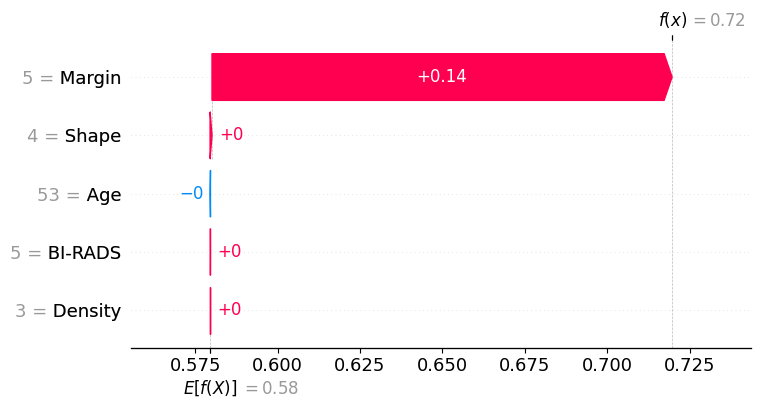

In [45]:
explain_with_shap_UTA_DIS(model, x0, background_data, feature_names)

Model nauczył się podejmować decyzję głównie na podstawie cechy Margin. W analizowanym przypadku, to właśnie ta cecha miała największy wpływ na klasyfikację próbki do klasy 0, co zostało potwierdzone przez wartości współczynników oraz analizę SHAP.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi. Oznacza to, że minimalna modyfikacja jednej kluczowej cechy może skutecznie wpłynąć na decyzję modelu, jednak w tym konkretnym przypadku wartości wyliczone analitycznie były niemożliwe do osiągnięcia w praktyce.

### Przykład 2

In [46]:
x1 = torch.tensor(X_test[random_indices[1]:random_indices[1]+1], dtype=torch.float32)
print(f"\n====== Przykład 2 (indeks {random_indices[1]}) ======")
grads1, pred1 = explain_decision_uta_dis(model, x1, feature_names)
df_changes1, pred1 = minimal_change_to_flip_decision_uta_dis(model, x1, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(df_changes1)


====== Przykład 2 (indeks 136) ======
Prawdopodobieństwo klasy 1: 0.7197
Predykcja klasy: 1
Wpływ cech (gradienty):
- BI-RADS: 0.000132
- Age: 0.000108
- Shape: 0.002028
- Margin: 0.048186
- Density: 0.000109

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change    New Value
0  BI-RADS            5.0  0.000132     -7138.244141 -7133.244141
1      Age           55.0  0.000108     -8760.291016 -8705.291016
2    Shape            4.0  0.002028      -464.996368  -460.996368
3   Margin            5.0  0.048186       -19.570969   -14.570969
4  Density            3.0  0.000109     -8657.226562 -8654.226562


In [47]:
print("\nPróbkowanie zmian i ponowna predykcja:")
sample_and_predict_changes_uta_dis(model, x1, df_changes1, feature_names)


Próbkowanie zmian i ponowna predykcja:
Oryginalna klasa: 1

- Cecha BI-RADS: zmiana o -7209.6266, nowa wartość: -7204.6265
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -8847.8939, nowa wartość: -8792.8936
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -469.6463, nowa wartość: -465.6463
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -19.7667, nowa wartość: -14.7667
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Density: zmiana o -8743.7988, nowa wartość: -8740.7988
  Nowa predykcja: 0, zmiana klasy: TAK


  0%|          | 0/1 [00:00<?, ?it/s]

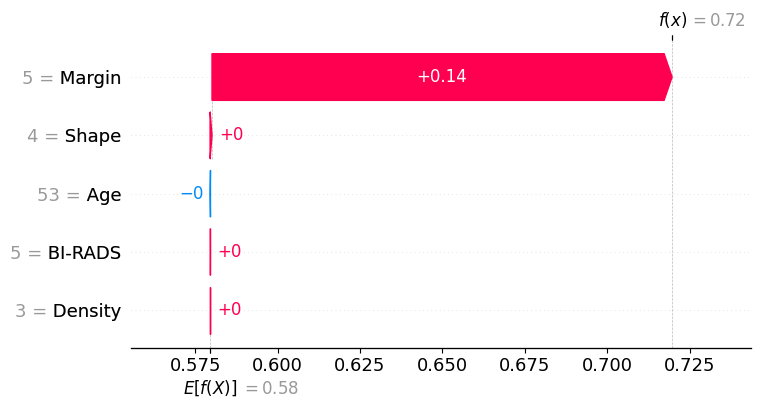

In [48]:
explain_with_shap_UTA_DIS(model, x1, background_data, feature_names)

Model nauczył się podejmować decyzję głównie na podstawie cechy Margin. W analizowanym przypadku, to właśnie ta cecha miała największy wpływ na klasyfikację próbki do klasy 1, co zostało potwierdzone przez wartości współczynników oraz analizę SHAP.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi. Oznacza to, że minimalna modyfikacja jednej kluczowej cechy może skutecznie wpłynąć na decyzję modelu, jednak w tym konkretnym przypadku wartości wyliczone analitycznie były niemożliwe do osiągnięcia w praktyce.

### Przykład 3

In [49]:
x2 = torch.tensor(X_test[random_indices[2]:random_indices[2]+1], dtype=torch.float32)
print(f"\n====== Przykład 3 (indeks {random_indices[2]}) ======")
grads2, pred2 = explain_decision_uta_dis(model, x2, feature_names)
df_changes2, pred2 = minimal_change_to_flip_decision_uta_dis(model, x2, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(df_changes2)


====== Przykład 3 (indeks 78) ======
Prawdopodobieństwo klasy 1: 0.3899
Predykcja klasy: 0
Wpływ cech (gradienty):
- BI-RADS: 0.000132
- Age: 0.000108
- Shape: 0.002028
- Margin: 0.048186
- Density: 0.000109

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change    New Value
0  BI-RADS            4.0  0.000132      3387.599854  3391.599854
1      Age           56.0  0.000108      4157.375488  4213.375488
2    Shape            1.0  0.002028       220.673553   221.673553
3   Margin            1.0  0.048186         9.287805    10.287805
4  Density            3.0  0.000109      4108.464355  4111.464355


In [50]:
print("\nPróbkowanie zmian i ponowna predykcja:")
sample_and_predict_changes_uta_dis(model, x2, df_changes2, feature_names)


Próbkowanie zmian i ponowna predykcja:
Oryginalna klasa: 0

- Cecha BI-RADS: zmiana o 3421.4759, nowa wartość: 3425.4758
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 4198.9492, nowa wartość: 4254.9492
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 222.8803, nowa wartość: 223.8803
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 9.3807, nowa wartość: 10.3807
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Density: zmiana o 4149.5490, nowa wartość: 4152.5488
  Nowa predykcja: 1, zmiana klasy: TAK


  0%|          | 0/1 [00:00<?, ?it/s]

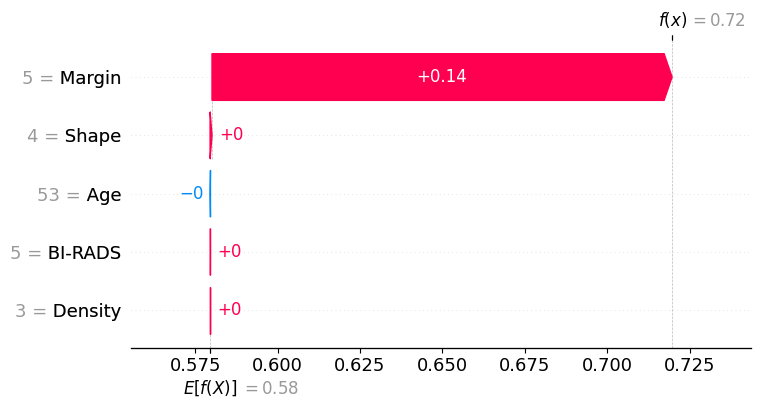

In [51]:
explain_with_shap_UTA_DIS(model, x1, background_data, feature_names)

Model nauczył się podejmować decyzję głównie na podstawie cechy Margin. W analizowanym przypadku, to właśnie ta cecha miała największy wpływ na klasyfikację próbki do klasy 1, co zostało potwierdzone przez wartości współczynników oraz analizę SHAP.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi. Oznacza to, że minimalna modyfikacja jednej kluczowej cechy może skutecznie wpłynąć na decyzję modelu, jednak w tym konkretnym przypadku wartości wyliczone analitycznie były niemożliwe do osiągnięcia w praktyce.

## Interpretacja modelu

Margin: wpływ na dokładność = 0.2530
BI-RADS: wpływ na dokładność = 0.0000
Age: wpływ na dokładność = 0.0000
Shape: wpływ na dokładność = 0.0000
Density: wpływ na dokładność = 0.0000


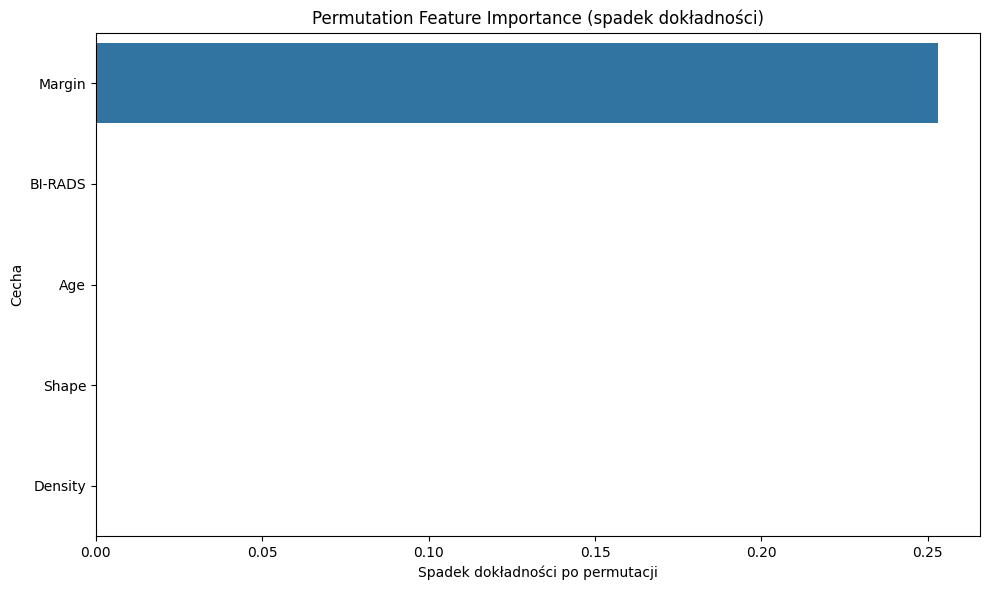

In [52]:
def compute_permutation_importance(model, dataloader, feature_names):
    model.eval()
    base_preds = []
    base_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            logits = model(x_batch)
            probs = torch.sigmoid(logits)
            preds_class = (probs > 0.5).long().squeeze()
            base_preds.append(preds_class.cpu().numpy())
            base_labels.append(y_batch.cpu().numpy())

    base_preds = np.concatenate(base_preds)
    base_labels = np.concatenate(base_labels)
    base_acc = accuracy_score(base_labels, base_preds)

    importances = []

    for feature_idx, name in enumerate(feature_names):
        shuffled_preds = []

        with torch.no_grad():
            for x_batch, y_batch in dataloader:
                x_shuffled = x_batch.clone()
                shuffled_column = x_shuffled[:, feature_idx].cpu().numpy()
                np.random.shuffle(shuffled_column)
                x_shuffled[:, feature_idx] = torch.tensor(shuffled_column).to(x_batch.device)

                logits = model(x_shuffled)
                probs = torch.sigmoid(logits)
                preds_class = (probs > 0.5).long().squeeze()
                shuffled_preds.append(preds_class.cpu().numpy())

        shuffled_preds = np.concatenate(shuffled_preds)
        acc_after_shuffle = accuracy_score(base_labels, shuffled_preds)
        importance = base_acc - acc_after_shuffle
        importances.append((name, importance))

    return sorted(importances, key=lambda x: x[1], reverse=True)

importances = compute_permutation_importance(model, test_dataloader, feature_names)

for name, imp in importances:
    print(f"{name}: wpływ na dokładność = {imp:.4f}")

# Wykres
df_imp = pd.DataFrame(importances, columns=["Feature", "Importance"])
plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x="Importance", y="Feature", color='C0')
plt.title("Permutation Feature Importance (spadek dokładności)")
plt.xlabel("Spadek dokładności po permutacji")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()


Model UTA-ANN przewiduje prawdopodobieństwo wystąpienia złośliwego guza piersi (klasa 1) na podstawie wartości cech diagnostycznych. W celu interpretacji zastosowano technikę Permutation Feature Importance.

Analiza wykazała, że spośród wszystkich cech jedynie Margin ma istotny wpływ na decyzje modelu — przetasowanie tej cechy powoduje wyraźny spadek dokładności klasyfikacji. Pozostałe cechy mają znikomy lub zerowy wpływ, co oznacza, że model praktycznie ignoruje je przy podejmowaniu decyzji.

Wszystkie cechy są monotoniczne, zgodnie z założeniami architektury UTA. Tylko cecha Margin działa jak cecha typu zysk — jej wyższa wartość zwiększa prawdopodobieństwo klasyfikacji jako złośliwy guz. Nie zaobserwowano progów preferencji ani obszarów nierozróżnialności — wpływ cech (dla Margin) zmienia się płynnie.

Wyniki uzyskane z techniki permutacji są spójne z analizą modelu — potwierdzają, że Margin jest jedyną decydującą cechą w podejmowaniu decyzji przez model.

---

## Sieć neuronowa

### Przygotowanie danych

In [53]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

df = pd.read_csv('data/mammographic.csv')
df = df[df.iloc[:, 0] != 55]

num_criteria = 5
feature_names = df.columns[:num_criteria].tolist()

X = df[feature_names]
y = df.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

generator = torch.Generator().manual_seed(42)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Architektura modelu

In [54]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(5, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.block(x)

### Trenowanie modelu

In [55]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    stats_train = {'losses': [], 'acc_scores': [], 'f1_scores': [], 'auc_scores': []}
    stats_test = {'losses': [], 'acc_scores': [], 'f1_scores': [], 'auc_scores': []}

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_true = []
        train_pred = []

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_true.extend(y_batch.numpy())
            train_pred.extend(preds.detach().numpy())

        train_loss = sum(train_losses) / len(train_losses)
        train_acc = accuracy_score(train_true, train_pred)
        train_f1 = f1_score(train_true, train_pred)
        train_auc = roc_auc_score(train_true, train_pred)

        stats_train['losses'].append(train_loss)
        stats_train['acc_scores'].append(train_acc)
        stats_train['f1_scores'].append(train_f1)
        stats_train['auc_scores'].append(train_auc)

        model.eval()
        test_losses = []
        test_true = []
        test_pred = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch).squeeze(1)
                loss = criterion(outputs, y_batch)
                test_losses.append(loss.item())

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                test_true.extend(y_batch.numpy())
                test_pred.extend(preds.numpy())

        test_loss = sum(test_losses) / len(test_losses)
        test_acc = accuracy_score(test_true, test_pred)
        test_f1 = f1_score(test_true, test_pred)
        test_auc = roc_auc_score(test_true, test_pred)

        stats_test['losses'].append(test_loss)
        stats_test['acc_scores'].append(test_acc)
        stats_test['f1_scores'].append(test_f1)
        stats_test['auc_scores'].append(test_auc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
                  f"Test Acc: {test_acc:.4f} | F1: {test_f1:.4f} | AUC: {test_auc:.4f}")

    return stats_train, stats_test

In [56]:
model = NeuralNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
set_seed(42)
stats_train, stats_test = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)

Epoch [5/50] Train Loss: 0.3866 | Test Loss: 0.3299 | Test Acc: 0.8554 | F1: 0.8125 | AUC: 0.8474
Epoch [10/50] Train Loss: 0.3793 | Test Loss: 0.3313 | Test Acc: 0.8554 | F1: 0.8125 | AUC: 0.8474
Epoch [15/50] Train Loss: 0.3732 | Test Loss: 0.3767 | Test Acc: 0.8554 | F1: 0.8235 | AUC: 0.8591
Epoch [20/50] Train Loss: 0.3689 | Test Loss: 0.3522 | Test Acc: 0.8313 | F1: 0.7879 | AUC: 0.8278
Epoch [25/50] Train Loss: 0.3663 | Test Loss: 0.3642 | Test Acc: 0.8313 | F1: 0.7879 | AUC: 0.8278
Epoch [30/50] Train Loss: 0.3677 | Test Loss: 0.3356 | Test Acc: 0.8313 | F1: 0.7879 | AUC: 0.8278
Epoch [35/50] Train Loss: 0.3646 | Test Loss: 0.3392 | Test Acc: 0.8434 | F1: 0.8000 | AUC: 0.8376
Epoch [40/50] Train Loss: 0.3604 | Test Loss: 0.3521 | Test Acc: 0.8313 | F1: 0.7879 | AUC: 0.8278
Epoch [45/50] Train Loss: 0.3571 | Test Loss: 0.3219 | Test Acc: 0.8434 | F1: 0.8000 | AUC: 0.8376
Epoch [50/50] Train Loss: 0.3580 | Test Loss: 0.3673 | Test Acc: 0.8072 | F1: 0.7647 | AUC: 0.8082


## Metryki

In [57]:
def plot_stats(stats_train, stats_test):
    fig = plt.figure(figsize=(18, 5))

    # Loss
    ax = fig.add_subplot(1, 4, 1)
    ax.plot(stats_train['losses'], label='Train')
    ax.plot(stats_test['losses'], label='Test')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # AUC
    ax = fig.add_subplot(1, 4, 2)
    ax.plot(stats_train['auc_scores'], label='Train')
    ax.plot(stats_test['auc_scores'], label='Test')
    ax.set_title('AUC')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.legend()

    # Accuracy
    ax = fig.add_subplot(1, 4, 3)
    ax.plot(stats_train['acc_scores'], label='Train')
    ax.plot(stats_test['acc_scores'], label='Test')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

    # F1
    ax = fig.add_subplot(1, 4, 4)
    ax.plot(stats_train['f1_scores'], label='Train')
    ax.plot(stats_test['f1_scores'], label='Test')
    ax.set_title('F1 Score')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1')
    ax.legend()

    plt.tight_layout()
    plt.show()

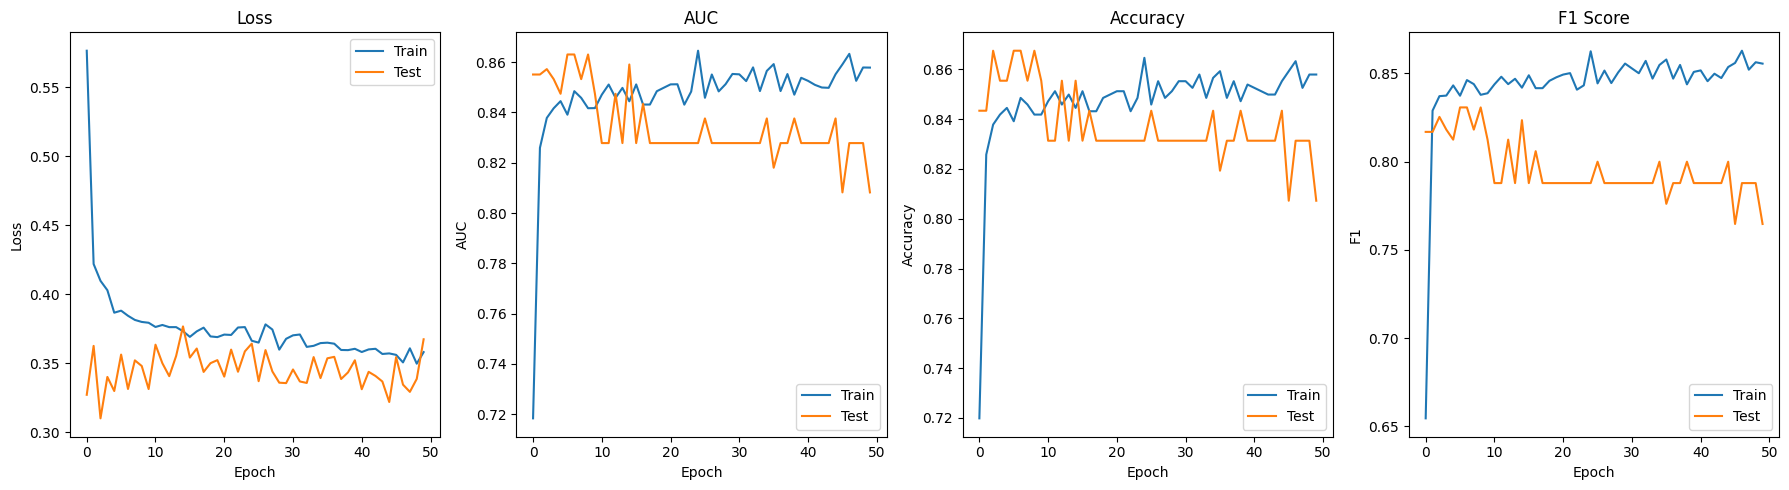

In [58]:
plot_stats(stats_train, stats_test)

- Model zaczął różnicować klasy już na wczesnym etapie treningu — znaczące poprawy metryk obserwowane są już po 5 epokach, co świadczy o szybkim przyswajaniu wzorców przez model.
- Testowe metryki osiągają stabilne wartości około 15. epoki, po czym utrzymują się na podobnym poziomie do końca treningu. Taka stabilność sugeruje brak przeuczenia oraz dobre właściwości generalizacyjne modelu.
- Od 15. epoki metryki testowe nie poprawiają się istotnie, co może oznaczać osiągnięcie punktu nasycenia — dalsze uczenie nie przynosi już zauważalnych korzyści.

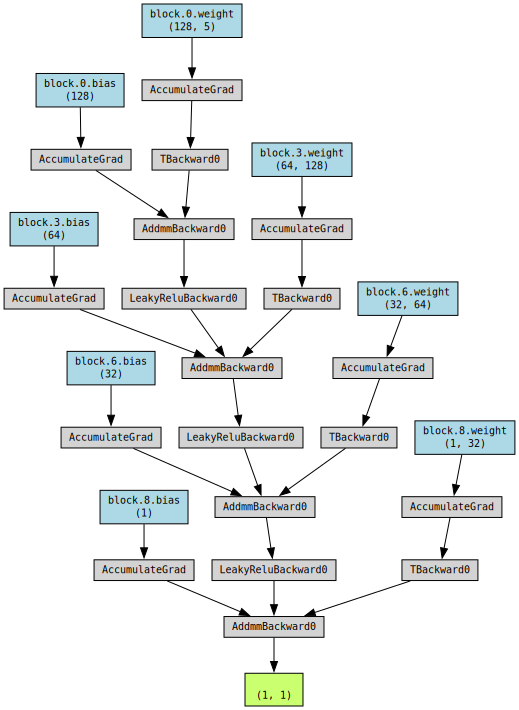

In [59]:
x = torch.randn(1, 5)
y = model(x)

dot = make_dot(y, params=dict(model.named_parameters()))
svg_str = dot.pipe(format='svg').decode('utf-8')

display(SVG(svg_str))

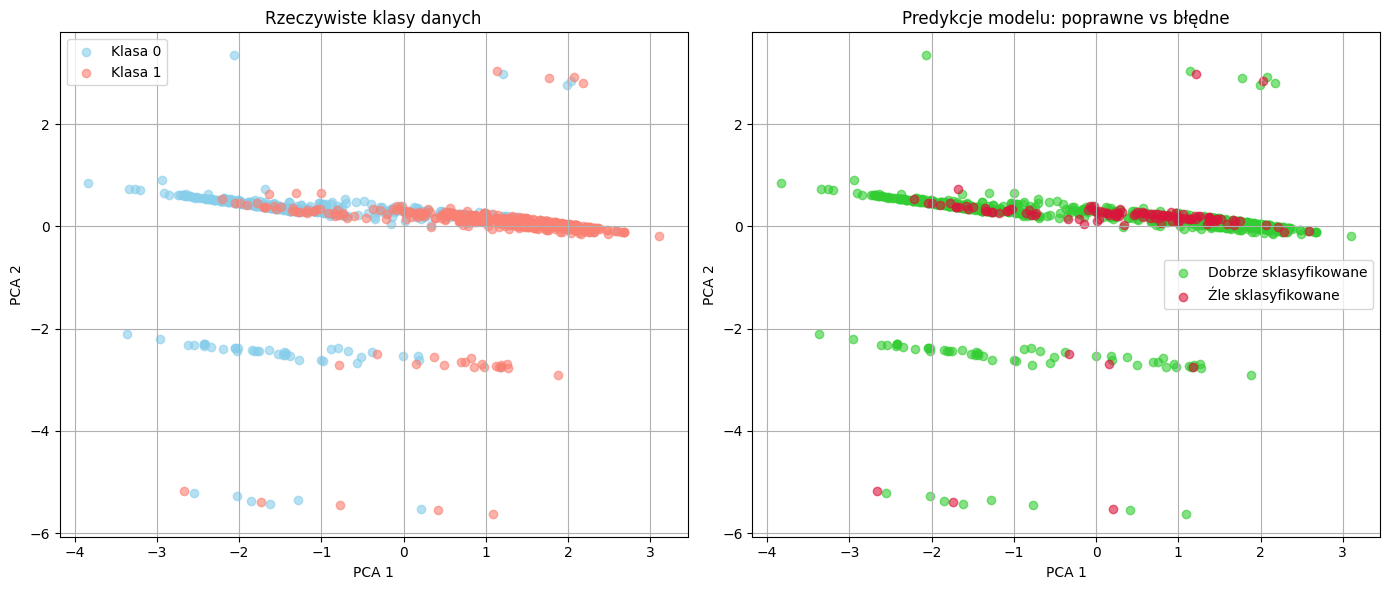

In [60]:
def collect_all_data(loader):
    all_features = []
    all_labels = []
    for X_batch, y_batch in loader:
        all_features.append(X_batch)
        all_labels.append(y_batch)
    X_all = torch.cat(all_features, dim=0)
    y_all = torch.cat(all_labels, dim=0)
    return X_all, y_all

X_train_all, y_train_all = collect_all_data(train_loader)
X_test_all, y_test_all = collect_all_data(test_loader)
X_total = torch.cat([X_train_all, X_test_all], dim=0)
y_total = torch.cat([y_train_all, y_test_all], dim=0)

X_total_flat = X_total.view(X_total.size(0), -1).numpy()
y_total_np = y_total.numpy()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_total_flat)

model.eval()
with torch.no_grad():
    outputs = model(X_total).squeeze()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

correct = (preds == y_total).numpy()
incorrect = ~correct

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(X_pca[y_total_np == 0, 0], X_pca[y_total_np == 0, 1], label='Klasa 0', alpha=0.6, c='skyblue')
axs[0].scatter(X_pca[y_total_np == 1, 0], X_pca[y_total_np == 1, 1], label='Klasa 1', alpha=0.6, c='salmon')
axs[0].set_title('Rzeczywiste klasy danych')
axs[0].set_xlabel('PCA 1')
axs[0].set_ylabel('PCA 2')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(X_pca[correct, 0], X_pca[correct, 1], c='limegreen', label='Dobrze sklasyfikowane', alpha=0.6)
axs[1].scatter(X_pca[incorrect, 0], X_pca[incorrect, 1], c='crimson', label='Źle sklasyfikowane', alpha=0.6)
axs[1].set_title('Predykcje modelu: poprawne vs błędne')
axs[1].set_xlabel('PCA 1')
axs[1].set_ylabel('PCA 2')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Interpretacja wizualizacji

Przeprowadzona wizualizacja danych za pomocą PCA umożliwiła redukcję wymiarowości do dwóch głównych składowych, co pozwoliło na łatwiejszą interpretację rozkładu próbek. Na wykresie widać wyraźne skupienia odpowiadające poszczególnym klasom, co sugeruje, że dane są w dużym stopniu liniowo separowalne w przestrzeni zredukowanej. To tłumaczy, dlaczego model radzi sobie dobrze z klasyfikacją, osiągając wysokie wartości metryk. Zauważalne jest jednak pewne nakładanie się punktów, co może wskazywać na trudniejsze przypadki, które model musi rozstrzygać. Ogólnie rzecz biorąc, analiza PCA potwierdza, że struktura danych jest odpowiednia do efektywnego uczenia modelu.

### Wyjaśnienie wybranych decyzji

In [ ]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 3, replace=False)
background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

[30  0 22]


### Obliczanie minimalnej zmiany metodą gradientową

In [62]:
def minimal_change_to_flip_decision_NN(model, input_tensor, feature_names):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    output = model(input_tensor)

    logit = output.item()
    prob = torch.sigmoid(output).item()
    pred_class = int(prob > 0.5)

    output.backward()
    grads = input_tensor.grad[0].detach().numpy()

    margin = logit

    changes = []
    for i in range(input_tensor.shape[1]):
        grad = grads[i]
        delta = -margin / grad if grad != 0 else np.inf
        changes.append({
            'Feature': feature_names[i],
            'Current Value': input_tensor[0, i].item(),
            'Gradient': grad,
            'Required Change': delta,
            'New Value': input_tensor[0, i].item() + delta,
        })

    df = pd.DataFrame(changes)
    return df, pred_class, prob

In [63]:
def sample_and_predict_changes_NN(model, input_tensor, df_changes, feature_names):
    model.eval()
    with torch.no_grad():
        original_output = model(input_tensor)
        original_prob = torch.sigmoid(original_output).item()
        print(original_output)
        original_pred = int(original_prob > 0.5)

    print(f"Oryginalna klasa: {original_pred}\n")

    for _, row in df_changes.iterrows():
        if np.isinf(row['Required Change']):
            print(f"- Cecha {row['Feature']} ma zerowy gradient, brak wpływu na predykcję.")
            continue

        modified_input = input_tensor.clone().detach()
        delta = row['Required Change'] * 1.01
        idx = feature_names.index(row['Feature'])
        modified_input[0, idx] += delta

        with torch.no_grad():
            new_output = model(modified_input)
            new_prob = torch.sigmoid(new_output).item()
            print(new_output, new_prob)
            new_pred = int(new_prob > 0.5)

        changed = "TAK" if new_pred != original_pred else "NIE"
        print(f"- Cecha {row['Feature']}: zmiana o {delta:.4f}, nowa wartość: {modified_input[0, idx].item():.4f}")
        print(f"  Nowa predykcja: {new_pred}, zmiana klasy: {changed}")


In [64]:
def explain_with_shap_NN(model, input_tensor, background_data, feature_names):
    model.eval()

    background_tensor = torch.tensor(background_data, dtype=torch.float32)
    explainer = shap.GradientExplainer(model, background_tensor)

    shap_values = explainer.shap_values(input_tensor)

    shap.initjs()

    x_np = input_tensor.detach().cpu().numpy().reshape(-1)

    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[0].reshape(-1),
            base_values=model(background_tensor).sigmoid().mean().item(),
            data=x_np,
            feature_names=feature_names
        ),
        max_display=len(feature_names)
    )

### Przykład 1

In [65]:
x0 = X_test_tensor[random_indices[0]].unsqueeze(0)
print(f"\n====== Przykład 1 (indeks {random_indices[0]}) ======")

changes_df, pred_class, prob = minimal_change_to_flip_decision_NN(model, x0, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(changes_df)

sample_and_predict_changes_NN(model, x0, changes_df, feature_names)


====== Przykład 1 (indeks 30) ======

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change  New Value
0  BI-RADS      -0.484091  0.743856         1.612604   1.128512
1      Age       0.491297  1.336771         0.897345   1.388642
2    Shape      -1.433958  0.069323        17.303703  15.869745
3   Margin      -1.156887  0.048031        24.974445  23.817558
4  Density       0.240619  0.184946         6.485905   6.726525
tensor([[-1.1995]])
Oryginalna klasa: 0

tensor([[1.4537]]) 0.8105655908584595
- Cecha BI-RADS: zmiana o 1.6287, nowa wartość: 1.1446
  Nowa predykcja: 1, zmiana klasy: TAK
tensor([[-0.6730]]) 0.33782362937927246
- Cecha Age: zmiana o 0.9063, nowa wartość: 1.3976
  Nowa predykcja: 0, zmiana klasy: NIE
tensor([[5.5980]]) 0.9963083863258362
- Cecha Shape: zmiana o 17.4767, nowa wartość: 16.0428
  Nowa predykcja: 1, zmiana klasy: TAK
tensor([[8.2210]]) 0.9997311234474182
- Cecha Margin: zmiana o 25.2242, nowa wartość: 24.06

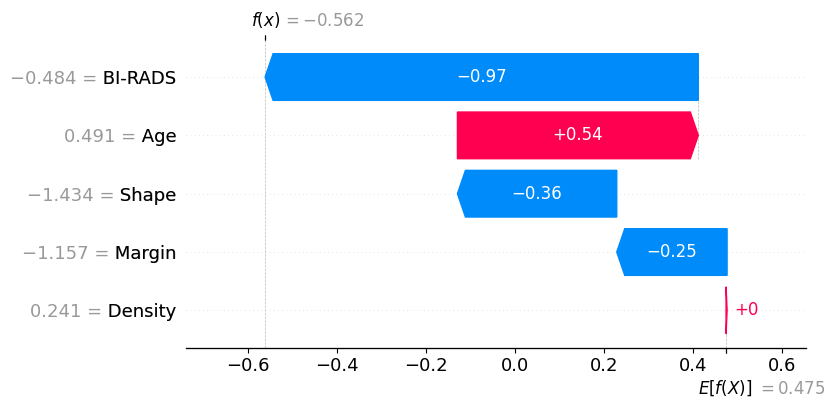

In [66]:
explain_with_shap_NN(model, x0, background_data, feature_names)

Model przypisał obserwację do klasy 0.

Największy negatywny wpływ na zmianę decyzji miały cechy: BI-RADS, Shape oraz Margin.
Cecha Age zwiększa prawdopodobieństwo przynależności do klasy 1, a wpływ Density jest pomijalny.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany przewidziane analitycznie nie potwierdziło zmiany klasy. Wynika to z faktu, że modele neuronowe są nieliniowe i lokalna, liniowa aproksymacja (np. gradient) nie zawsze dokładnie przewiduje rzeczywistą granicę decyzyjną. W praktyce oznacza to, że nawet precyzyjnie obliczone minimalne zmiany cech mogą nie być wystarczające do zmiany klasy, ponieważ model może wymagać większych lub bardziej skomplikowanych perturbacji.

### Przykład 2

In [67]:
x1 = X_test_tensor[random_indices[1]].unsqueeze(0)
print(f"\n====== Przykład 2 (indeks {random_indices[0]}) ======")

changes_df, pred_class, prob = minimal_change_to_flip_decision_NN(model, x1, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(changes_df)

sample_and_predict_changes_NN(model, x1, changes_df, feature_names)


====== Przykład 2 (indeks 30) ======

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change  New Value
0  BI-RADS      -0.484091  1.466136         2.652309   2.168218
1      Age      -2.372109  1.123724         3.460498   1.088389
2    Shape      -0.628571  0.827800         4.697569   4.068998
3   Margin      -1.156887 -0.787916        -4.935359  -6.092245
4  Density       0.240619 -0.087906       -44.236198 -43.995579
tensor([[-3.8886]])
Oryginalna klasa: 0

tensor([[5.4250]]) 0.9956141710281372
- Cecha BI-RADS: zmiana o 2.6788, nowa wartość: 2.1947
  Nowa predykcja: 1, zmiana klasy: TAK
tensor([[-1.0061]]) 0.26774588227272034
- Cecha Age: zmiana o 3.4951, nowa wartość: 1.1230
  Nowa predykcja: 0, zmiana klasy: NIE
tensor([[0.3903]]) 0.5963507890701294
- Cecha Shape: zmiana o 4.7445, nowa wartość: 4.1160
  Nowa predykcja: 1, zmiana klasy: TAK
tensor([[-1.9702]]) 0.12236929684877396
- Cecha Margin: zmiana o -4.9847, nowa wartość: -6.14

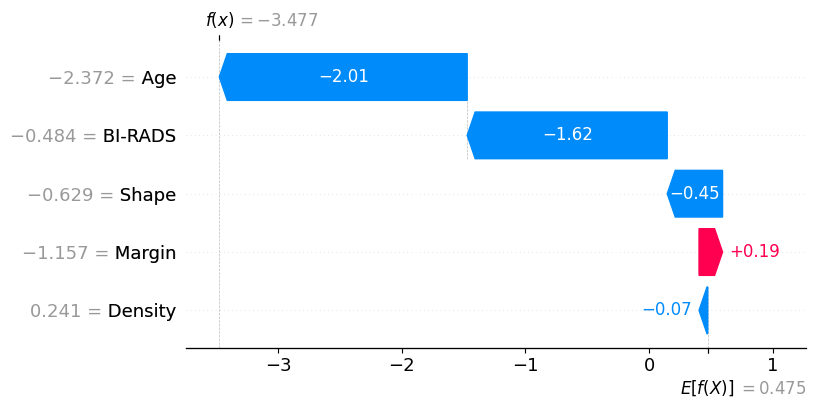

In [68]:
explain_with_shap_NN(model, x1, background_data, feature_names)

Model przypisał obserwację do klasy 0.

Największy negatywny wpływ na zmianę decyzji miały cechy: Age, BI-RADS oraz Shape.
Wpływ cech Density i Margin jest znikomy.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany przewidziane analitycznie nie potwierdziło zmiany klasy. Wynika to z faktu, że modele neuronowe są nieliniowe i lokalna, liniowa aproksymacja (np. gradient) nie zawsze dokładnie przewiduje rzeczywistą granicę decyzyjną. W praktyce oznacza to, że nawet precyzyjnie obliczone minimalne zmiany cech mogą nie być wystarczające do zmiany klasy, ponieważ model może wymagać większych lub bardziej skomplikowanych perturbacji.

### Przykład 3

In [69]:
x2 = X_test_tensor[random_indices[2]].unsqueeze(0)
print(f"\n====== Przykład 3 (indeks {random_indices[0]}) ======")

changes_df, pred_class, prob = minimal_change_to_flip_decision_NN(model, x2, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(changes_df)

sample_and_predict_changes_NN(model, x2, changes_df, feature_names)


====== Przykład 3 (indeks 30) ======

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change  New Value
0  BI-RADS       0.969937  0.111476        -8.896976  -7.927040
1      Age      -0.190466 -0.456186         2.174109   1.983643
2    Shape       0.176816  0.044381       -22.347431 -22.170616
3   Margin       0.757403  0.550582        -1.801363  -1.043961
4  Density       3.090241  0.192819        -5.143662  -2.053421
tensor([[0.9918]])
Oryginalna klasa: 1

tensor([[3.2827]]) 0.9638296961784363
- Cecha BI-RADS: zmiana o -8.9859, nowa wartość: -8.0160
  Nowa predykcja: 1, zmiana klasy: NIE
tensor([[0.2350]]) 0.558479905128479
- Cecha Age: zmiana o 2.1959, nowa wartość: 2.0054
  Nowa predykcja: 1, zmiana klasy: NIE
tensor([[-0.9008]]) 0.28888940811157227
- Cecha Shape: zmiana o -22.5709, nowa wartość: -22.3941
  Nowa predykcja: 0, zmiana klasy: TAK
tensor([[0.0232]]) 0.5057889819145203
- Cecha Margin: zmiana o -1.8194, nowa wartość: -1.

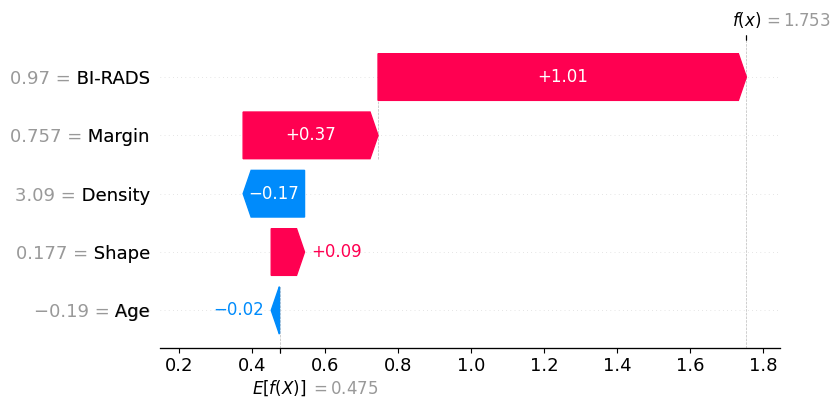

In [70]:
explain_with_shap_NN(model, x2, background_data, feature_names)

Model przypisał obserwację do klasy 1.

Największy pozytywny wpływ na zmianę decyzji miały cechy: BI-RADS, Shape oraz Margin.
Cechy Age i Density zmniejszają prawdopodobieństwo przynależności do klasy 1, jednak wpływ Age jest znikomy.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany przewidziane analitycznie nie potwierdziło zmiany klasy. Wynika to z faktu, że modele neuronowe są nieliniowe i lokalna, liniowa aproksymacja (np. gradient) nie zawsze dokładnie przewiduje rzeczywistą granicę decyzyjną. W praktyce oznacza to, że nawet precyzyjnie obliczone minimalne zmiany cech mogą nie być wystarczające do zmiany klasy, ponieważ model może wymagać większych lub bardziej skomplikowanych perturbacji.

## Interpretacja modelu

Dokładność surrogate modelu: 0.9518


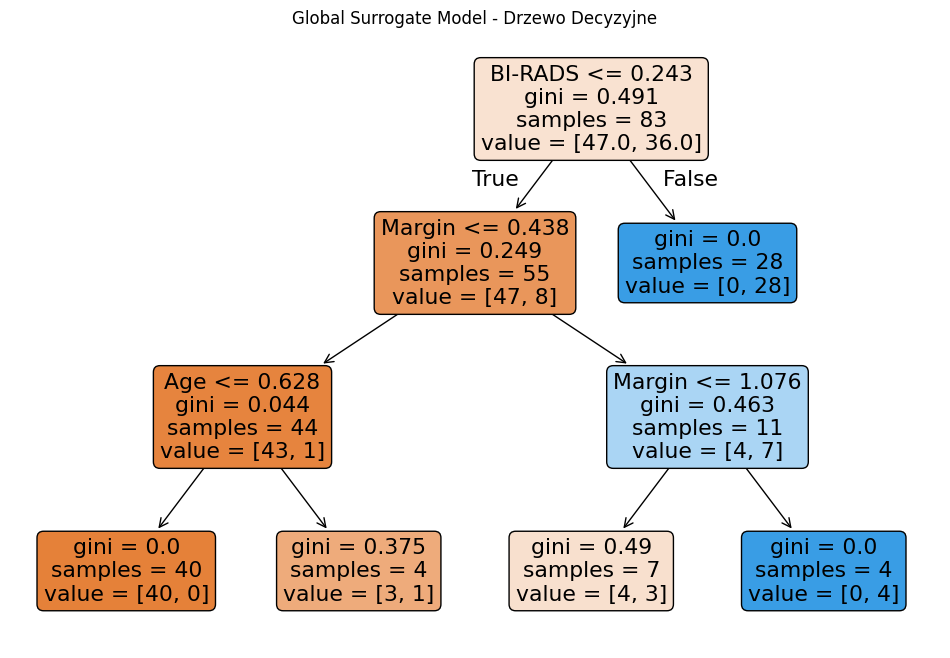

In [71]:
X_np = X_test.numpy() if isinstance(X_test, torch.Tensor) else X_test
y_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test

def predict_proba_numpy(X):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).numpy().flatten()
    return probs

y_pred_model = (predict_proba_numpy(X_np) > 0.5).astype(int)

surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_np, y_pred_model)

accuracy = accuracy_score(y_pred_model, surrogate.predict(X_np))
print(f"Dokładność surrogate modelu: {accuracy:.4f}")

plt.figure(figsize=(12, 8))
plot_tree(surrogate, feature_names=feature_names, filled=True, rounded=True)
plt.title("Global Surrogate Model - Drzewo Decyzyjne")
plt.show()

Drzewo decyzyjne surrogate modelu wskazuje, że najważniejszym kryterium decyzyjnym jest BI-RADS – wartość powyżej 0.24 prowadzi bezpośrednio do klasy 1. Dla niższych wartości decydują kolejne cechy: Margin i w jednej gałęzi Age. Shape i Density nie wystąpiły w drzewie, co sugeruje ich marginalny wpływ w tym uproszczeniu.

Preferencje użytkowników są mocno związane z BI-RADS – jest to główny czynnik decyzyjny. Margin ma istotny wpływ tylko przy niższym BI-RADS, a Age nie zmienia wyniku klasyfikacji, więc jego wpływ jest znikomy. Shape i Density zostały pominięte – mogą nie mieć znaczenia w tym kontekście.

Charakter cech:
- BI-RADS: monotoniczny (im wyższy, tym większe ryzyko),
- Margin: niemonotoniczny (tylko bardzo wysokie wartości zwiększają ryzyko),
- Age: neutralny,
- Shape i Density: pomijalne.

Progi preferencji: BI-RADS = 0.24 oraz Margin = 1.08. Wartości Age poniżej i powyżej 0.63 są nierozróżnialne, podobnie jak niewykorzystane Shape i Density – ich różnice nie wpływają na decyzję modelu.

Należy pamiętać, że uproszczone drzewo nie oddaje w pełni złożoności oryginalnego modelu, który może uwzględniać zależności nieliniowe i interakcje między cechami.


---

## Podsumowanie

W analizie porównano trzy różne podejścia do modelowania decyzji:

- Prosty, interpretowalny model ML (regresja logistyczna),
- Model ANN-MCDA (ANN-UTADIS),
- Złożony model sieci neuronowej z kilkoma warstwami ukrytymi i nieliniową funkcją aktywacji.

Mimo że sposób podejmowania decyzji przez każdy z modeli był inny, to efekty końcowebyły bardzo zbliżone.

Oznacza to, że nawet prostsze, bardziej interpretowalne modele są w stanie uchwycić główne wzorce decyzyjne zawarte w danych, co jest istotne z punktu widzenia przejrzystości i zaufania do systemu. Z kolei modele złożone oferują większą elastyczność, ale kosztem transparentności.

To potwierdza, że wybór modelu powinien zależeć nie tylko od dokładności, ale również od potrzeby interpretacji i zrozumienia kryteriów decyzyjnych.